In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
kaggle_data_folder = "/media/vincentwang/Backup/kaggle_data/ventilator-pressure-prediction"
output_folder = "../output/"

In [7]:
train = pd.read_csv(kaggle_data_folder + "/train.csv")
test = pd.read_csv(kaggle_data_folder + "/test.csv")
submission = pd.read_csv(kaggle_data_folder + "/sample_submission.csv")

In [8]:
display(train.shape, test.shape, submission.shape)
display(train.head())
display(test.head())
display(submission.head())

(6036000, 8)

(4024000, 7)

(4024000, 2)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# EDA

In [12]:
train.groupby("breath_id").size().unique(), test.groupby("breath_id").size().unique(), len(train.id.unique())

(array([80]), array([80]), 6036000)

In [15]:
np.all(train.groupby("breath_id")["u_out"].apply(lambda s: s.diff().sum()) == 1)

True

<AxesSubplot:>

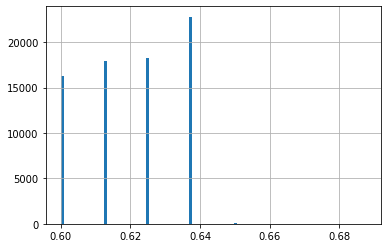

In [14]:
breath_len = 80
(train.groupby("breath_id")['u_out'].mean()).hist(bins=100)

In [37]:
train.groupby(["R","C"]).size() // 80

R   C 
5   10     8312
    20     8277
    50     8271
20  10     6070
    20     6208
    50     8186
50  10    13677
    20     8260
    50     8189
dtype: int64

In [38]:
test.groupby(["R","C"]).size() // 80

R   C 
5   10    5437
    20    5451
    50    5447
20  10    4292
    20    4088
    50    5500
50  10    9081
    20    5503
    50    5501
dtype: int64

In [34]:
def plot_breath(idx, train, ax):
    breath_seq = train.query(f"breath_id == {idx}").reset_index(drop=True)
    R, C = breath_seq.loc[0, ['R','C']]
    breath_seq.set_index('time_step',inplace=True,drop=True)
    u_in = breath_seq['u_in']
    change_place = breath_seq['u_out'].diff().idxmax()
    pressure = breath_seq["pressure"]
    
    ax.set_title(f"id {idx}: R {int(R)}, C {int(C)}")
    ax.plot(u_in, label="u_in", color="b")
    ax.axvline(x=change_place, linestyle="--", alpha=1, label="0->1", color="black")
    ax2 = ax.twinx()
    ax2.plot(pressure, label="pressure", color="r")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    return 

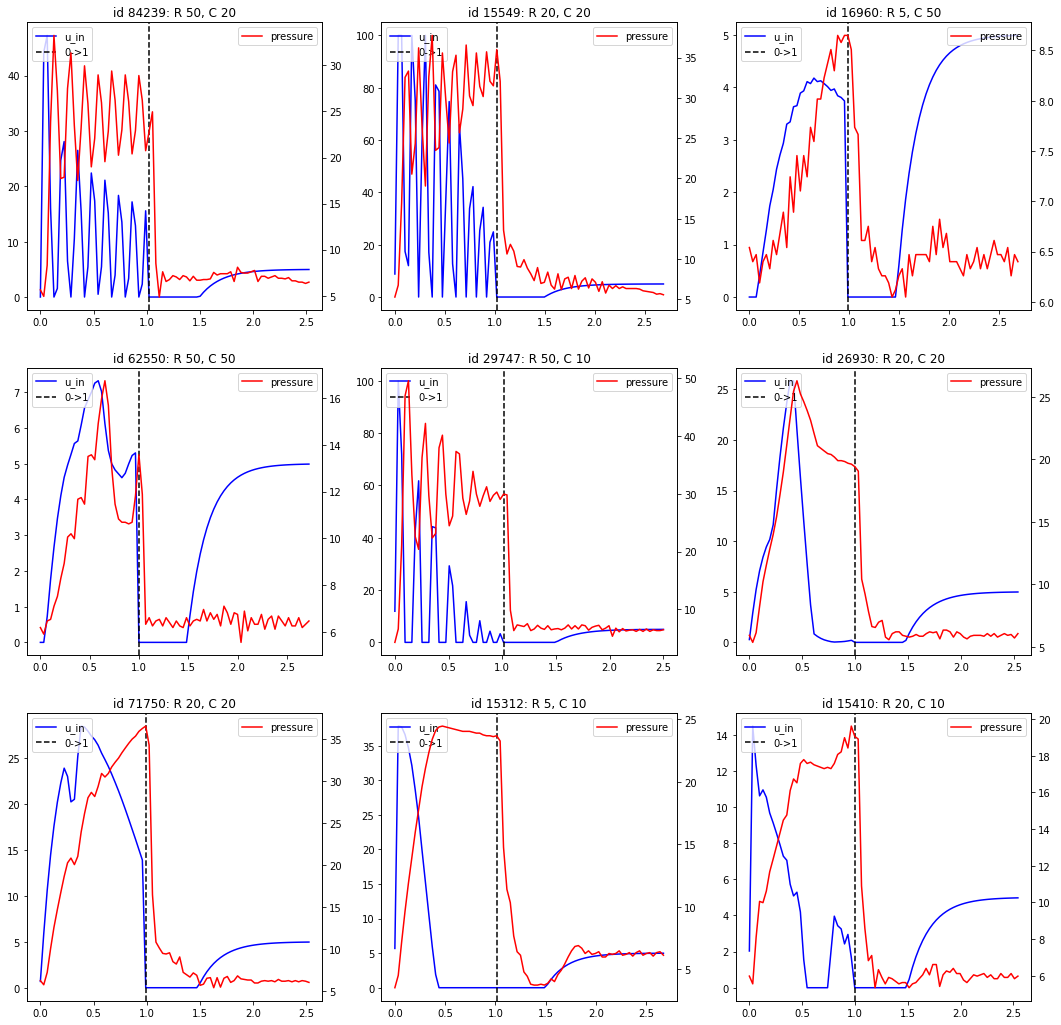

In [35]:
ids = train.breath_id.unique()
np.random.seed(10)
ids_sub = np.random.choice(ids, 9)
fig, axes = plt.subplots(3,3, figsize=(18,18))
for i, ax in enumerate(axes.flat):
    plot_breath(ids_sub[i], train, ax)

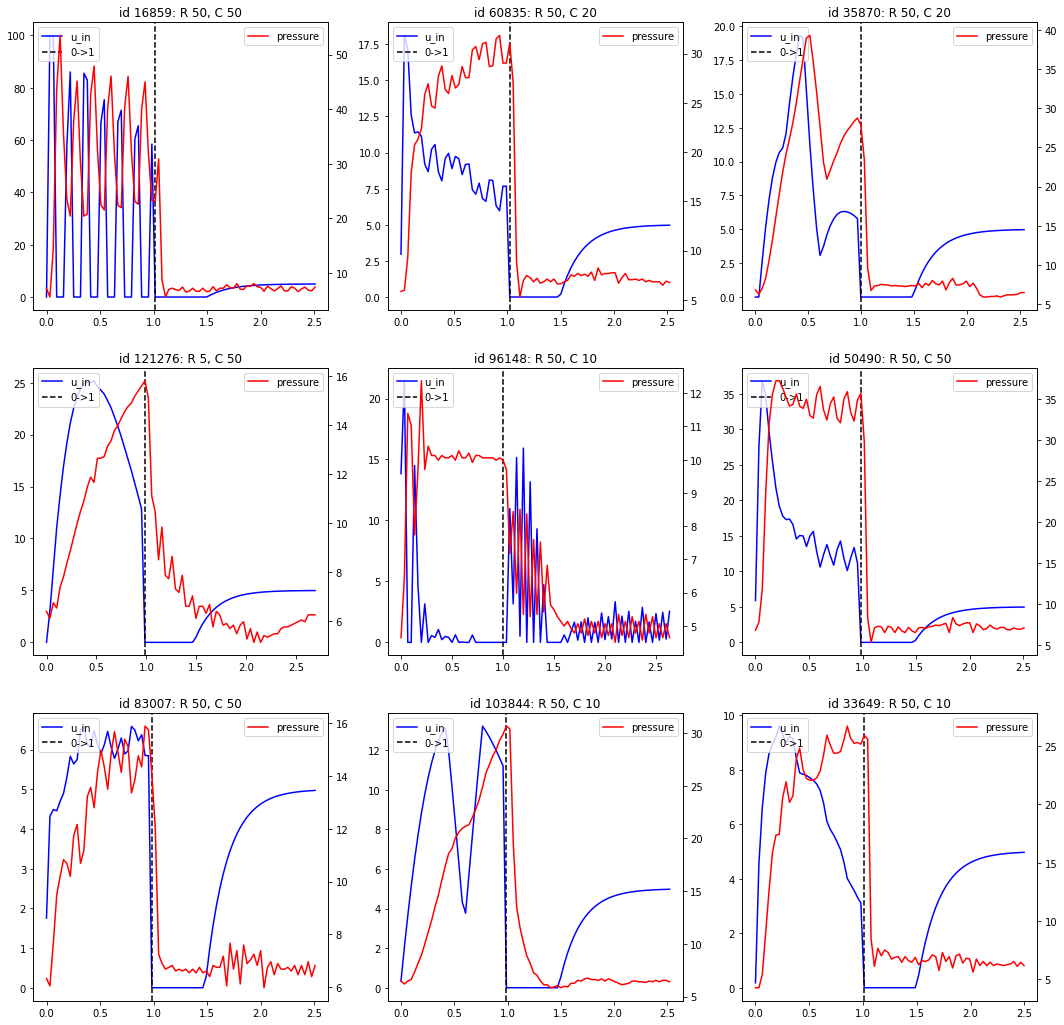

In [36]:
np.random.seed(11)
ids_sub = np.random.choice(ids, 9)
fig, axes = plt.subplots(3,3, figsize=(18,18))
for i, ax in enumerate(axes.flat):
    plot_breath(ids_sub[i], train, ax)

# Features
1. u_out portion

In [45]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    for shift in range(1,5):
        df[f'u_in_lag{shift}'] = df.groupby('breath_id')['u_in'].shift(shift)
        df[f'u_out_lag{shift}'] = df.groupby('breath_id')['u_out'].shift(shift)
        df[f'u_in_lag_back{shift}'] = df.groupby('breath_id')['u_in'].shift(-shift)
        df[f'u_out_lag_back{shift}'] = df.groupby('breath_id')['u_out'].shift(-shift)
        df[f'u_in_diff{shift}'] = df['u_in'] - df[f'u_in_lag{shift}']
        df[f'u_out_diff{shift}'] = df['u_out'] - df[f'u_out_lag{shift}']
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_out__mean'] = df.groupby(['breath_id'])['u_out'].transform('mean')
        
    df['breath_id__u_in__diffmax'] = df['breath_id__u_in__max'] - df['u_in']
    df['breath_id__u_in__diffmean'] = df['breath_id__u_in__mean'] - df['u_in']
        
    df['cross']= df['u_in']*(1 - df['u_out'])
    df['cross2']= df['time_step']*(1 - df['u_out'])
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [46]:
train = add_features(train)
test = add_features(test)

In [49]:
assert [col for col in train.columns if col != "pressure"] == list(test.columns)
train.shape, test.shape

((6036000, 54), (4024000, 53))